In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from clean import *
from train import *
from models import *
import argparse
import scipy.io.wavfile as wavf
import scipy.signal
import scipy.fft


In [3]:
def normalize_float(mic_data: np.ndarray, gain: float = 1.0):
    """Normalize microphone's data by removing DC offset and adding gain.

    The input data type is np.int16, and the output data type is np.float32.
    The input data has shape (mic_num, N), where mic_num is the number of
    microphones and N is the number of samples.  Also, the data range will be
    normalized from [-32768, 32767] to [-1, 1).
    """
    dtype = mic_data.dtype
    mic_data = (mic_data - np.mean(mic_data, axis=1, keepdims=True)) * gain
    # Manually clip the data to prevent overflow.
    mic_data = np.clip(mic_data, np.iinfo(dtype).min, np.iinfo(dtype).max)
    # Normalize data range.
    mic_data /= (np.iinfo(dtype).max + 1.0)

    return mic_data.astype(np.float32)

def batch_windowed_fft(mic_array_data: np.ndarray, fs: int):
    """Compute the FFT with Hann window of a microphone array's data in batch.

    Input:
    - mic_data: Mic array data, ndarray of shape (N, L), where N is the number
    of microphones and L is the data's sample length. The whole data for each
    microphone is treated as one FFT frame, and this is the difference between
    this function and batch_stft().
    - fs: sampling rate.
    - frame_time: time of one FFT frame, unit: s. (i.e. 0.025 denotes 25 ms)

    Returns:
    - f_FFT: array of sampling frequencies corresponds to each FFT bin.
    - fft_data: Result of the STFT. An ndarray of shape (N, L'), where N is the
    number of microphones and L' is the FFT length.
    """
    window = scipy.signal.get_window('hann', mic_array_data.shape[1])
    # Use orthogonal norm so that the scale of fft_data is roughly independent
    # of the length of input.
    fft_data = scipy.fft.rfft(mic_array_data * window, norm='ortho')
    f_FFT = np.linspace(0, fs / 2, mic_array_data.shape[1] // 2 + 1)
    # Somehow rfft()'s return type is float64 and complex128, so we need to
    # manually convert it to float32 and complex64.
    return f_FFT.astype(np.float32), fft_data.astype(np.complex64)

def fft_freq_clipping(f_FFT: np.ndarray, f_low, f_high):
    """Clip an FFT frequency bin by frequency lower bounds and upper bounds."""
    f_low_idx, f_high_idx = -1, -1
    if f_low <= f_FFT[0]:
        f_low_idx = 0
    if f_high >= f_FFT[-1]:
        f_high_idx = len(f_FFT)
    for i in range(len(f_FFT) - 1):
        if f_FFT[i] < f_low and f_FFT[i+1] >= f_low:
            f_low_idx = i + 1
        if f_FFT[i] <= f_high and f_FFT[i+1] > f_high:
            f_high_idx = i + 1
    if f_low_idx == -1 or f_high_idx == -1:
        raise RuntimeError('Incorrect FFT frequency bound')

    return f_low_idx, f_high_idx


## Step1: Format and clean the data

In [4]:
# Step1: Format and clean the data. Eliminating the sample with small amplitude
# Construct the argument
parser = argparse.ArgumentParser(description='Cleaning audio data')
parser.add_argument('--src_root', type=str, default='wavfiles',
                    help='directory of audio files in total duration')
parser.add_argument('--dst_root', type=str, default='clean',
                    help='directory to put audio files split by delta_time')
parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                    help='time in seconds to sample audio')
parser.add_argument('--sr', type=int, default=16000,
                    help='rate to downsample audio')
parser.add_argument('--plotfile', type=str, default='3a3d0279',
                    help='directory of audio files in total duration')
parser.add_argument('--threshold', type=str, default=20,
                    help='threshold magnitude for np.int16 dtype')
args, _ = parser.parse_known_args()


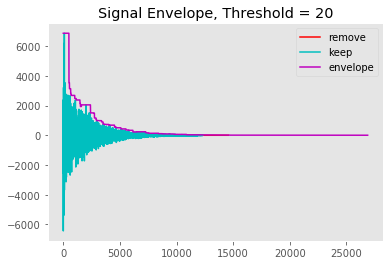

In [5]:
test_threshold(args)

In [113]:
# Split the long wav file into small segments, which has sample time equal to delta_time set in previous cell
split_wavs(args)

  0%|          | 0/30 [00:00<?, ?it/s]

clean exists
clean\Acoustic_guitar does not exist


 10%|█         | 3/30 [00:00<00:01, 20.85it/s]

clean\Bass_drum does not exist


  3%|▎         | 1/30 [00:00<00:03,  8.00it/s]

clean\Cello does not exist


  3%|▎         | 1/30 [00:00<00:03,  7.48it/s]

clean\Clarinet does not exist


  7%|▋         | 2/30 [00:00<00:02, 13.28it/s]

clean\Double_bass does not exist


  3%|▎         | 1/30 [00:00<00:05,  5.62it/s]

clean\Flute does not exist


  3%|▎         | 1/30 [00:00<00:03,  9.17it/s]

clean\Hi_hat does not exist


  7%|▋         | 2/30 [00:00<00:02, 10.49it/s]

clean\Saxophone does not exist


  0%|          | 0/30 [00:00<?, ?it/s]

clean\Snare_drum does not exist


  3%|▎         | 1/30 [00:00<00:04,  6.07it/s]

clean\Violin_or_fiddle does not exist


100%|██████████| 30/30 [00:03<00:00,  8.14it/s]


## Step2 Training the model based on existing data

In [6]:
# Prepare the parameter for usage
parser = argparse.ArgumentParser(description='Audio Classification Training')
parser.add_argument('--model_type', type=str, default='lstm',
                        help='model to run. i.e. conv1d, conv2d, lstm')
parser.add_argument('--src_root', type=str, default='clean',
                        help='directory of audio files in total duration')
parser.add_argument('--batch_size', type=int, default=16,
                        help='batch size')
parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
parser.add_argument('--sample_rate', '-sr', type=int, default=16000,
                        help='sample rate of clean audio')
args, _ = parser.parse_known_args()

In [7]:
print(args)

Namespace(batch_size=16, delta_time=1.0, model_type='lstm', sample_rate=16000, src_root='clean')


In [8]:
src_root = args.src_root
sr = args.sample_rate
dt = args.delta_time
batch_size = args.batch_size
model_type = args.model_type

In [9]:
params = {'N_CLASSES':len(os.listdir(args.src_root)),
            'SR':sr,
            'DT':dt}
print(params)

{'N_CLASSES': 10, 'SR': 16000, 'DT': 1.0}


In [10]:
models = {'conv1d':Conv1D(**params),
            'conv2d':Conv2D(**params),
            'lstm':  LSTM(**params)}

In [11]:
assert model_type in models.keys(), '{} not an available model'.format(model_type)

In [12]:
csv_path = os.path.join('logs', '{}_history.csv'.format(model_type))

In [13]:
wav_paths = glob('{}/**'.format(src_root), recursive=True)
print(wav_paths[2])
wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x]
print(len(wav_paths))

clean\Acoustic_guitar\0356dec7_0.wav
1290


In [14]:
classes = sorted(os.listdir(args.src_root))
print(classes)

['Acoustic_guitar', 'Bass_drum', 'Cello', 'Clarinet', 'Double_bass', 'Flute', 'Hi_hat', 'Saxophone', 'Snare_drum', 'Violin_or_fiddle']


In [16]:
le = LabelEncoder()
le.fit(classes)
labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
labels = le.transform(labels)
print(labels)

[0 0 0 ... 9 9 9]


In [17]:
# The currrent wav_train and wav_val are the path to the wav file
wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                labels,
                                                                test_size=0.1,
                                                                random_state=0)

In [18]:
assert len(label_train) >= args.batch_size, 'Number of train samples must be >= batch_size'

In [19]:
print(len(set(label_train)) == params['N_CLASSES'])
print(len(set(label_val)) == params['N_CLASSES'])

True
True


In [157]:
#    def __init__(self, wav_paths, labels, sr, dt, n_classes,
#                 batch_size=32, shuffle=True):
tg = DataGenerator(wav_train, label_train, sr, dt,
                    params['N_CLASSES'], batch_size=batch_size)

## Step3: Training with my own dataset

In [4]:
# Step1: Load our wav file(60s), preprocessing to STFT as a 2D feature
# Refer to helper.py in ultramic

def load_clean_signal(file_list, file_dir):
    """Load audio files from a single mic.

    Input:
    - file_list: a list of the audio file's name, length: N. The sampling rate
    and length of each audio file should be identical.
    - filedir: name of the directory containing the audio files.

    Returns:
    - mic_array_signal: an ndarray of shape (N, L), where L is the length of the
    signal. dtype: float32.
    - fs: sampling rate.
    """
    mic_signal_list = []
    for file in file_list:
        file_path = os.path.join(file_dir, file)
        fs, single_mic_signal = wavf.read(file_path)
        mic_signal_list.append(single_mic_signal)

    single_mic_data = np.stack(mic_signal_list)
    return single_mic_data, fs

In [5]:
file_dir = "wavfiles_ultramic/Drill/"
file_list = os.listdir(file_dir)
Drill_wav,fs = load_clean_signal(file_list,file_dir)

In [6]:
file_dir = "wavfiles_ultramic/Shaver/"
file_list = os.listdir(file_dir)
Shaver_wav,fs = load_clean_signal(file_list,file_dir)

In [7]:
print("Shape of Drill wav:",Drill_wav.shape)
print("Shape of Shaver wav:",Shaver_wav.shape)
print("Fs:",fs)

Shape of Drill wav: (1, 5760000)
Shape of Shaver wav: (1, 5760000)
Fs: 96000


In [8]:
#Finish loading, then add the same normalization and gain as what we did in ultramic preprocessing
normalize_gain = (np.iinfo(Drill_wav.dtype).max +
                    1.0) / Drill_wav.max()
Drill_wav_norm = normalize_float(Drill_wav, normalize_gain)
Shaver_wav_norm = normalize_float(Shaver_wav, normalize_gain)

In [9]:
#Clip each single object file into small segment with time period 0.2s
delta_sample = int(0.2 * fs)
Drill_wav_norm = Drill_wav_norm.reshape(-1,delta_sample)
Shaver_wav_norm = Shaver_wav_norm.reshape(-1,delta_sample)
wav_stack = np.stack([Drill_wav_norm,Shaver_wav_norm])
print(wav_stack.shape)

(2, 300, 19200)


In [10]:
#Refer to ultramic code, we manually do stft on each small segment
window_len = 1024
hop_len = 512
sample_start_idx = np.arange(0,delta_sample,hop_len)

#Adjust the sample_start_idx into suitable size so that we don't need to pad zero in the end
for i in range(len(sample_start_idx)-1,-1,-1):
    if(sample_start_idx[i]+window_len<delta_sample):
        sample_start_idx = sample_start_idx[0:i+1]
        break

stft_object = []
#Iterate on Object
for n in range(wav_stack.shape[0]):
    stft_time_segment = []
    #Iterate on time segment
    for m in range(wav_stack.shape[1]):
        window_sample = np.stack([wav_stack[n,m,i:i+window_len] for i in sample_start_idx])
        f_FFT,fft_data = batch_windowed_fft(window_sample,fs)
        stft_time_segment.append(fft_data)
    stft_object.append(stft_time_segment)
print(np.stack(stft_object).shape)

(2, 300, 36, 513)


In [12]:
f_low = 16000
f_high = 40000
f_low_del = 24000
f_high_del = 26000
f_low_idx,f_high_idx = fft_freq_clipping(f_FFT, f_low, f_high)
f_low_didx,f_high_didx = fft_freq_clipping(f_FFT, f_low_del, f_high_del)
print(f_low_idx,f_high_idx)
print(f_low_didx,f_high_didx)

171 427
256 278


In [26]:
stft_object_clipping_1 = np.stack(stft_object)[:,:,:,f_low_idx:f_low_didx]
stft_object_clipping_2 = np.stack(stft_object)[:,:,:,f_high_didx:f_high_idx]
stft_object_clipping=np.abs(np.concatenate([stft_object_clipping_1,stft_object_clipping_2],axis=-1))
print(stft_object_clipping.shape)
stft_object_clipping /= np.max(stft_object_clipping)
stft_object_clipping = np.log10(stft_object_clipping)

(2, 300, 36, 234)


In [27]:
np.save("stft_object_clipping.npy",np.abs(stft_object_clipping))

In [28]:
from matplotlib import pyplot as plt

Text(0, 0.5, 'Frequency(Hz)')

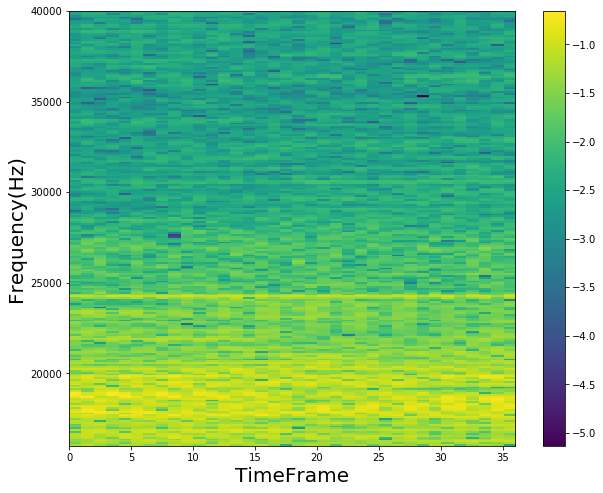

In [31]:
fig,ax = plt.subplots(figsize=(10,8))
img = ax.imshow(stft_object_clipping[1,0,:,:].T,aspect="auto",origin="lower",extent=[0,stft_object_clipping.shape[2],f_low,f_high])
fig.colorbar(img,ax=ax)
#ax.set_yticks(f_FFT[0:-1:10])
ax.set_xlabel("TimeFrame",fontsize=20)
ax.set_ylabel("Frequency(Hz)",fontsize=20)